In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import shutil

In [2]:
#functions only for documentation
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def draw_bounding_boxes(image, min_area, max_area, scale = 2, max_ratio = 2):

    inverted_mask = cv2.bitwise_not(create_binary_mask(image))  # Invert the mask to get contours on the foreground
    
    contours, _ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    counter = 0

    for contour in contours:
        contour_area = cv2.contourArea(contour)
        
        if min_area <= contour_area <= max_area:
            counter += 1
            x, y, w, h = cv2.boundingRect(contour)
            x,y,w,h = scale_rect(x,y,w,h, scale) #scaling, because the contour misses fine details
            if w == 0 or h == 0:
                continue
            ratio = max(w, h) / min(w, h) #calculating ratio to filter out rectangles not "square enough"
            if ratio <= max_ratio:
                cv2.rectangle(image, (x, y), (x + w, y + h), (255), thickness=2)
                
    print(f"{counter} bounding boxes found.")
    return image

def plot_grid(image, stride):
    height, width = image.shape[:2]

    # Draw vertical lines
    for x in range(0, width, stride):
        cv2.line(image, (x, 0), (x, height), color=(0, 0, 255), thickness=2)

    # Draw horizontal lines
    for y in range(0, height, stride):
        cv2.line(image, (0, y), (width, y), color=(0,0, 255), thickness=2)

    return image

def filter_contours_by_area(image, binary_mask, min_area, max_area, scale = 2, max_ratio = 2):
    inverted_mask = cv2.bitwise_not(binary_mask)  # Invert the mask to get contours on the foreground
    
    # Find contours
    contours, _ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a new mask to store the filtered contours (rectangles)
    counter = 0
    # Loop through each contour
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        
        # Check if the contour is within the min and max area range
        if min_area <= contour_area <= max_area:
            counter += 1
            # Get the bounding rectangle of the contour
            x, y, w, h = cv2.boundingRect(contour)
            x,y,w,h = scale_rect(x,y,w,h, scale)
            if w == 0 or h == 0:
                continue  # skip invalid rectangles
            ratio = max(w, h) / min(w, h)
            if ratio <= max_ratio:
            # Draw a rectangle around the contour on the new mask
                cv2.rectangle(image, (x, y), (x + w, y + h), (255), thickness=2)
    print(counter)
    return image, counter

In [3]:
#functions for preprocessing

#creates the binary mask needed for finding contours
def create_binary_mask(image):
    '''
    binary masking with manual set threshold (yellow) taken from the checkpot-project
    '''
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask

#crops the image to only the YST
def crop(image):
    '''
    the biggest contour is taken
    '''
    mask = create_binary_mask(image)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            cropped_image = image[y:y+h, x:x+w]
    return cropped_image

#masks out background features
def mask_background(image):
    '''
        creates two white bars, one vertical over the dotted line, one horizontal over the inscription
    '''
    height, width = image.shape[:2]
    middle = width//2
    beam_color = (255,255,255)
    
    #vertical bar
    beam_width = 400
    top_left = (middle - beam_width//2, 0)
    bottom_right = (middle + beam_width//2, height)
    cv2.rectangle(image, top_left, bottom_right, beam_color, thickness = -1)
    
    #horizontal bar
    beam_width = 2500
    beam_height = 800
    top_left = (middle - beam_width//2, 0)
    bottom_right = (middle + beam_width//2, beam_height)
    cv2.rectangle(image, top_left, bottom_right, beam_color, thickness = -1)
    
    return image

def scale_rect(x, y, w, h, scale):
    """
    Scales a rectangle around its center.
    """
    # Center of original rectangle
    cx = x + w / 2
    cy = y + h / 2

    # New width and height
    new_w = w * scale
    new_h = h * scale

    # New top-left corner
    new_x = cx - new_w / 2
    new_y = cy - new_h / 2

    return int(new_x), int(new_y), int(new_w), int(new_h)


def get_list_of_rectangles(image, min_area, max_area, scale = 2, max_ratio = 2):
    ''' 
        returns a list of bounding boxes for an image (scaled and filtered by "squareness")
        scale: scale factor
        max_ratio: ratio w / h allowed maximally
    '''
    rectangles = []
    
    inverted_mask = cv2.bitwise_not(create_binary_mask(image))  # Invert the mask to get contours on the foreground
    
    contours, _ = cv2.findContours(inverted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        
        if min_area <= contour_area <= max_area:
            x, y, w, h = cv2.boundingRect(contour)
            x,y,w,h = scale_rect(x,y,w,h, scale) #scaling, because the contour misses fine details
            if w == 0 or h == 0:
                continue  # skip invalid rectangles
            ratio = max(w, h) / min(w, h) #calculating ratio to filter out rectangles not "square enough"
            if ratio <= max_ratio:
                rectangles.append([x,y,w,h])
    return rectangles

def pad_image_to_stride(image, tile_size=640, stride=320):
    height, width = image.shape[:2]

    # Calculate how much padding is needed
    pad_bottom = (math.ceil((height - tile_size) / stride) + 1) * stride + tile_size - stride - height
    pad_right  = (math.ceil((width  - tile_size) / stride) + 1) * stride + tile_size - stride - width

    # Apply padding (bottom and right sides only)
    padded_image = cv2.copyMakeBorder(
        image, 0, pad_bottom, 0, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0)
    )

    return padded_image


def calculate_intersection_area(tile, rect):
    ''' 
        calculates the intersection of a tile and a rectangle(bounding box) and returns percentage
    '''
    # Calculate the coordinates of the intersection
    x1, y1, w1, h1 = rect
    tx, ty = tile
    x2 = tx + 640
    y2 = ty + 640
    
    # Find the intersection coordinates
    inter_x1 = max(x1, tx)
    inter_y1 = max(y1, ty)
    inter_x2 = min(x1 + w1, x2)
    inter_y2 = min(y1 + h1, y2)

    # Calculate the intersection area
    if inter_x2 > inter_x1 and inter_y2 > inter_y1:
        inter_width = inter_x2 - inter_x1
        inter_height = inter_y2 - inter_y1
        return inter_width * inter_height
    return 0


def check_overlap(tile, rect, overlap_threshold=0.1):
    '''
        checks if the intersection area exceeds a threshold and returns a boolean
    '''
    
    # Calculate the intersection area between the tile and the rectangle
    intersection_area = calculate_intersection_area(tile, rect)
    x, y, w, h = rect
    rect_area = w * h

    # Calculate the overlap percentage
    overlap_percentage = intersection_area / rect_area

    # If the overlap is greater than the threshold, return True
    return overlap_percentage >= overlap_threshold


def get_tiles_with_rectangles(image, rectangles, overlap_threshold=0.1):
    '''
        returns list with top left corner of tile and the rectangles in relation to the tile
        only tiles with rectangles are included
    '''
    # Pad image first
    tile_size = 640
    stride = 320
    padded_image = pad_image_to_stride(image, tile_size, stride)
    height, width = padded_image.shape[:2]
    
    tile_data = []

    for y in range(0, height - tile_size + 1, stride):
        for x in range(0, width - tile_size + 1, stride):
            tile = (x, y)
            relative_rects = []

            for rect in rectangles:
                if check_overlap(tile, rect, overlap_threshold):
                    # clip coordinates if they are past the tile
                    rx, ry, rw, rh = rect
                    clipped_x1 = max(rx, x)
                    clipped_y1 = max(ry, y)
                    clipped_x2 = min(rx + rw, x + tile_size)
                    clipped_y2 = min(ry + rh, y + tile_size)

                    # Convert to relative
                    rel_x = clipped_x1 - x
                    rel_y = clipped_y1 - y
                    rel_w = clipped_x2 - clipped_x1
                    rel_h = clipped_y2 - clipped_y1

                    # Only keep if it still has area
                    if rel_w > 0 and rel_h > 0:
                        relative_rects.append([rel_x, rel_y, rel_w, rel_h])

            if relative_rects:  # Only keep tiles that have at least one matching rect
                tile_data.append([(x, y), relative_rects])

    return tile_data, padded_image

def draw_tiles_with_rectangles(tile_data, padded_image, tile_size=640):
    '''
        returns a list of cv2 images which are the tiles selected
    '''
    tile_images = []
    for (tile_x, tile_y), rects in tile_data:
        tile_img = padded_image[tile_y:tile_y + tile_size, tile_x:tile_x + tile_size].copy()
        tile_images.append(tile_img)
    return tile_images

def generate_yolo_labels(tile_data, tile_size=640, class_id=0):
    '''
        returns the yolo_labels as list
    '''
    yolo_labels = []

    for i, ((tile_x, tile_y), rects) in enumerate(tile_data):
        tile_label_lines = []

        for rel_x, rel_y, w, h in rects:
            x_center = (rel_x + w / 2) / tile_size
            y_center = (rel_y + h / 2) / tile_size
            norm_w = w / tile_size
            norm_h = h / tile_size

            label_line = f"{class_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}"
            tile_label_lines.append(label_line)

        yolo_labels.append(tile_label_lines)

    return yolo_labels

### Documentation

1. Manually filtered for duplicates or lighting errors
2. Manually orientiated with the inscription on top

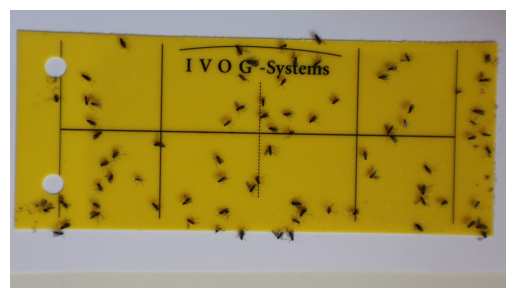

In [131]:
input_folder = '/user/christoph.wald/u15287/05_praktikum_final/data_raw'
testfile = "/train_BRAIIM0001.jpg"
image = cv2.imread(input_folder + testfile)
show(image)

Mask used for finding contours

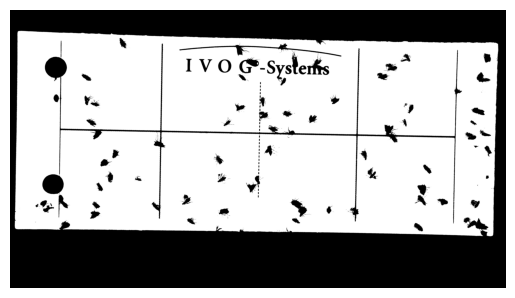

In [132]:
show(create_binary_mask(image))

3. Cropped image (taking the biggest contour, not strictly necessary)


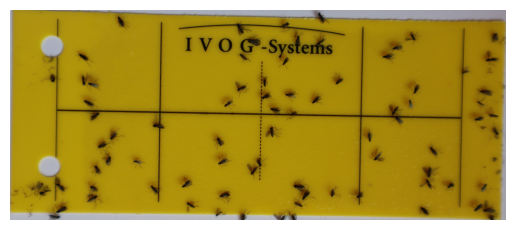

In [133]:
processed_image = crop(image)
show(processed_image)

4. Masked out difficult areas by plotting two white beams

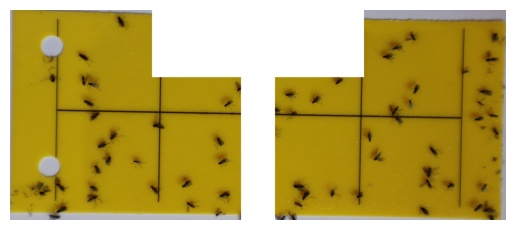

In [134]:
processed_image = mask_background(processed_image)
show(processed_image)

Draw Bounding Boxes

44 bounding boxes found.


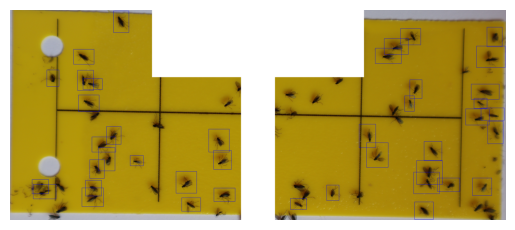

In [135]:
if "FRANOC" in testfile or "TRIAVA" in testfile:
        min_area = 100  # Define your minimum contour area
        max_area = 1000  # Define your maximum contour area
if "BRAIIM" in testfile or "LIRIBO" in testfile:
    min_area = 1000  # Define your minimum contour area
    max_area = 10000  # Define your maximum contour area   
show(draw_bounding_boxes(processed_image, min_area, max_area))


Tiles
Yolo takes 640x640 pictures (upper picture)
Tiles were made every 320 pixels (lower picture)

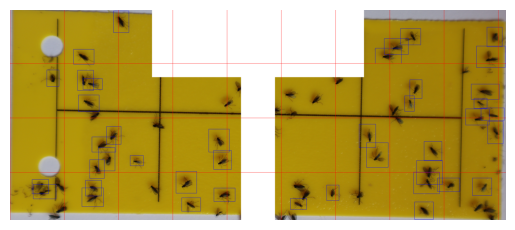

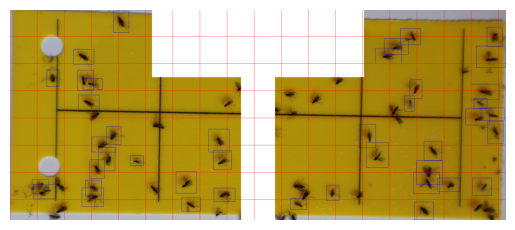

In [136]:
show(plot_grid(processed_image, 640))
show(plot_grid(processed_image, 320))

5. Create the training data

a) Find rectangles and scale them big enough

b) filter out rectangles (e.g. too large, not square enough)

c) slide through the padded image by 640x640 image with stride 320

d) check for intersection of rectangles, only keep when at least 75% are in the tile; clip rectangles to tile limits

e) create images and labels

In [137]:
image = cv2.imread(input_folder + testfile)
image = crop(image)
image = mask_background(image)
if "FRANOC" in testfile or "TRIAVA" in testfile:
        min_area = 100  # Define your minimum contour area
        max_area = 1000  # Define your maximum contour area
if "BRAIIM" in testfile or "LIRIBO" in testfile:
    min_area = 1000  # Define your minimum contour area
    max_area = 10000  # Define your maximum contour area   
rectangles= get_list_of_rectangles(image, min_area, max_area, scale = 2, max_ratio = 2)
print(f"{rectangles[0]} - this is bounding box with x,y coordinate for top left corner and width, height")

[4772, 2267, 222, 206] - this is bounding box with x,y coordinate for top left corner and width, height


[(4480, 0), [[0, 347, 218, 188], [127, 229, 238, 192]]]
This is a tile defined by the top left corner followed by a list of bounding boxes (coordinates in relation to the bounding box)
This is the padded image


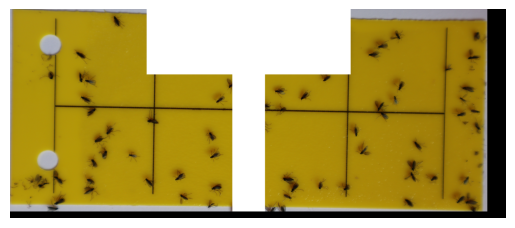

In [139]:
usable_tiles, image = get_tiles_with_rectangles(image, rectangles, overlap_threshold=0.75)
print(f"{usable_tiles[4]}")
print("This is a tile defined by the top left corner followed by a list of bounding boxes (coordinates in relation to the bounding box)")
print("This is the padded image")
show(image)


This is a tile


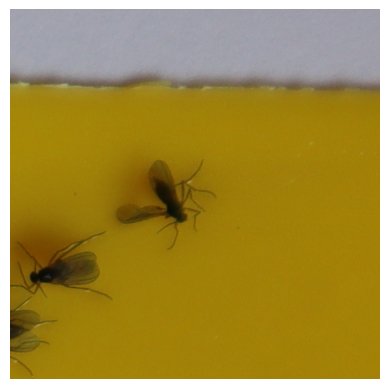

In [140]:
tile_images = draw_tiles_with_rectangles(usable_tiles, image, tile_size=640)
print("This is a tile")
show(tile_images[4])

In [141]:
labels = generate_yolo_labels(usable_tiles)
print("Yolo labels in the form <class> <x_center> <y_center> <width> <height> with values normalized to 1")
labels[4]

Yolo labels in the form <class> <x_center> <y_center> <width> <height> with values normalized to 1


['0 0.170313 0.689063 0.340625 0.293750',
 '0 0.384375 0.507812 0.371875 0.300000']

### Preprocessing

In [142]:
input_folder = '/user/christoph.wald/u15287/05_praktikum_final/data_raw'
output_folder = '/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed'
os.makedirs(output_folder, exist_ok=True)

In [143]:
# Process all images in the folder
for filename in os.listdir(input_folder):
    
    img_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    
    image = cv2.imread(img_path)
    processed_image = crop(image)
    processed_image = mask_background(processed_image)
    
    cv2.imwrite(output_path, processed_image)
    print(f"{filename} processed and saved to output.")

print("Processing complete.")

train_BRAIIM0001.jpg processed and saved to output.
train_BRAIIM0003.jpg processed and saved to output.
train_BRAIIM0004.jpg processed and saved to output.
train_BRAIIM0005.jpg processed and saved to output.
train_BRAIIM0006.jpg processed and saved to output.
train_BRAIIM0007.jpg processed and saved to output.
train_BRAIIM0009.jpg processed and saved to output.
train_BRAIIM0010.jpg processed and saved to output.
train_BRAIIM0012.jpg processed and saved to output.
train_BRAIIM0013.jpg processed and saved to output.
train_FRANOC0002.jpg processed and saved to output.
train_FRANOC0004.jpg processed and saved to output.
train_FRANOC0011.jpg processed and saved to output.
train_FRANOC0015.jpg processed and saved to output.
train_FRANOC0016.jpg processed and saved to output.
train_FRANOC0017.jpg processed and saved to output.
train_FRANOC0019.jpg processed and saved to output.
train_FRANOC0021.jpg processed and saved to output.
train_FRANOC0025.jpg processed and saved to output.
train_FRANOC

Preprocessing test pictures including bounding boxes generated by image processing

In [ ]:
input_folder = '/user/christoph.wald/u15287/05_praktikum_final/test_pictures_raw'
output_folder = '/user/christoph.wald/u15287/05_praktikum_final/test_pictures_preprocessed'
os.makedirs(output_folder, exist_ok=True)
# Process all images in the folder
for file in os.listdir(input_folder):
    
    img_path = os.path.join(input_folder, file)
    output_path = os.path.join(output_folder, file)
    
    image = cv2.imread(img_path)
    processed_image = crop(image)
    processed_image = mask_background(processed_image)
    mask = create_binary_mask(processed_image)
    if "FRANOC" in file or "TRIAVA" in file:
        min_area = 100  # Define your minimum contour area
        max_area = 1000  # Define your maximum contour area
    if "BRAIIM" in file or "LIRIBO" in file:
        min_area = 1000  # Define your minimum contour area
        max_area = 10000  # Define your maximum contour area   
    bounded_image, number = filter_contours_by_area(processed_image, mask, min_area, max_area)
    filename = os.path.join(output_folder, f"{file.rsplit('.',1)[0]}.jpg")
    cv2.imwrite(filename, bounded_image)


    print(f"{filename} processed and saved to output.")

print("Processing complete.")

Generating bounding boxes generated by image processing for the evaluation

In [5]:
input_folder = '/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed'
output_folder = '/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes'
os.makedirs(output_folder, exist_ok=True)
# Process all images in the folder
for file in os.listdir(input_folder):
    
    img_path = os.path.join(input_folder, file)
    output_path = os.path.join(output_folder, file)
    
    image = cv2.imread(img_path)
    mask = create_binary_mask(image)
    if "FRANOC" in file or "TRIAVA" in file:
        min_area = 100  # Define your minimum contour area
        max_area = 1000  # Define your maximum contour area
    if "BRAIIM" in file or "LIRIBO" in file:
        min_area = 1000  # Define your minimum contour area
        max_area = 10000  # Define your maximum contour area   
    bounded_image, number = filter_contours_by_area(image, mask, min_area, max_area)
    filename = os.path.join(output_folder, f"{file.rsplit('.',1)[0]}.jpg")
    cv2.imwrite(filename, bounded_image)
    #show(bounded_image)


    print(f"{filename} processed and saved to output.")

print("Processing complete.")

44
/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes/train_BRAIIM0001.jpg processed and saved to output.
40
/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes/train_BRAIIM0003.jpg processed and saved to output.
18
/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes/train_BRAIIM0004.jpg processed and saved to output.
40
/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes/train_BRAIIM0005.jpg processed and saved to output.
16
/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes/train_BRAIIM0006.jpg processed and saved to output.
22
/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes/train_BRAIIM0007.jpg processed and saved to output.
19
/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes/train_BRAIIM0009.jpg processed and saved to output.
27
/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed_w_bboxes/train_BRAIIM0010.jpg

### Creating Training Data

In [144]:
input_folder = '/user/christoph.wald/u15287/05_praktikum_final/data_preprocessed'
output_folder = '/user/christoph.wald/u15287/05_praktikum_final/tiles'
os.makedirs(output_folder, exist_ok=True)
pest_types = ["BRAIIM", "FRANOC", "LIRIBO", "TRIAVA"]

In [145]:
for file in os.listdir(input_folder):
    print(file)
    img_path = os.path.join(input_folder, file)
    image = cv2.imread(img_path)
    if "FRANOC" in file or "TRIAVA" in file:
        min_area = 100  # Define your minimum contour area
        max_area = 1000  # Define your maximum contour area
    if "BRAIIM" in file or "LIRIBO" in file:
        min_area = 1000  # Define your minimum contour area
        max_area = 10000  # Define your maximum contour area   
    rectangles= get_list_of_rectangles(image, min_area, max_area, scale = 2, max_ratio = 2)
    usable_tiles, image = get_tiles_with_rectangles(image, rectangles, overlap_threshold=0.75)
    tile_images = draw_tiles_with_rectangles(usable_tiles, image, tile_size=640)
    class_id = [id in file for id in pest_types].index(True)
    labels = generate_yolo_labels(usable_tiles, class_id=class_id)
    if len(tile_images) > 0:
        for i, img in enumerate(tile_images):
            filename = os.path.join(output_folder, f"{file.rsplit('.',1)[0]}_tile{i:03d}.jpg")
            cv2.imwrite(filename, img)
            filename = os.path.join(output_folder, f"{file.rsplit('.', 1)[0]}_tile{i:03d}.txt")
            with open(filename, "w") as f:
                for line in labels[i]:
                    f.write(line + "\n")
            
print("Processing complete.")

train_BRAIIM0001.jpg
train_BRAIIM0003.jpg
train_BRAIIM0004.jpg
train_BRAIIM0005.jpg
train_BRAIIM0006.jpg
train_BRAIIM0007.jpg
train_BRAIIM0009.jpg
train_BRAIIM0010.jpg
train_BRAIIM0012.jpg
train_BRAIIM0013.jpg
train_FRANOC0002.jpg
train_FRANOC0004.jpg
train_FRANOC0011.jpg
train_FRANOC0015.jpg
train_FRANOC0016.jpg
train_FRANOC0017.jpg
train_FRANOC0019.jpg
train_FRANOC0021.jpg
train_FRANOC0025.jpg
train_FRANOC0028.jpg
train_FRANOC0029.jpg
train_FRANOC0030.jpg
train_FRANOC0031.jpg
train_FRANOC0032.jpg
train_FRANOC0036.jpg
train_FRANOC0037.jpg
train_FRANOC0038.jpg
train_FRANOC0039.jpg
train_FRANOC0041.jpg
train_FRANOC0042.jpg
train_FRANOC0043.jpg
train_FRANOC0044.jpg
train_FRANOC0045.jpg
train_FRANOC0046.jpg
train_FRANOC0047.jpg
train_FRANOC0048.jpg
train_FRANOC0049.jpg
train_FRANOC0050.jpg
train_FRANOC0051.jpg
train_FRANOC0052.jpg
train_LIRIBO0001.jpg
train_LIRIBO0003.jpg
train_LIRIBO0007.jpg
train_LIRIBO0008.jpg
train_LIRIBO0010.jpg
train_LIRIBO0012.jpg
train_LIRIBO0013.jpg
train_LIRIBO0

### Train-test split

In [3]:
# Set paths
input_dir = "tiles"
base_dir = 'dataset'

# Output folders
img_train = os.path.join(base_dir, 'images/train')
img_val = os.path.join(base_dir, 'images/val')
lbl_train = os.path.join(base_dir, 'labels/train')
lbl_val = os.path.join(base_dir, 'labels/val')

# Create output folders
for d in [img_train, img_val, lbl_train, lbl_val]:
    os.makedirs(d, exist_ok=True)

In [4]:
pest_types = ["BRAIIM", "FRANOC", "LIRIBO", "TRIAVA"]
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))]
separated = []
for pest in pest_types:
    separated.append([f for f in image_files if pest in f])

In [9]:
train_files = []
val_files = []
for pest in separated:
    random.shuffle(pest)
    split_idx = int(len(pest) * 0.8)
    train_files.append(pest[:split_idx])
    val_files.append(pest[split_idx:])
train_files = [item for sublist in train_files for item in sublist]
val_files = [item for sublist in val_files for item in sublist]


In [ ]:
# Helper to move image and label together
def copy_pair(files, dest_img_dir, dest_lbl_dir):
    for f in files:
        src_img = os.path.join(input_dir, f)
        src_lbl = os.path.join(input_dir, f.replace('.jpg', '.txt'))

        dst_img = os.path.join(dest_img_dir, f)
        dst_lbl = os.path.join(dest_lbl_dir, os.path.basename(src_lbl))

        if os.path.exists(src_lbl):
            shutil.copy(src_img, dst_img)
            shutil.copy(src_lbl, dst_lbl)

# Move files
copy_pair(train_files, img_train, lbl_train)
copy_pair(val_files, img_val, lbl_val)

print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")

4

Counting

In [23]:
# Folder path to search
folder_path = "/user/christoph.wald/u15287/05_praktikum_final/dataset/labels/train"  # <- Change this to your target folder

# Keywords to look for in filenames
keywords = ["BRAIIM", "FRANOC", "LIRIBO", "TRIAVA"]

# Dictionary to store line counts for each keyword
line_counts = {keyword: 0 for keyword in keywords}

# Traverse the directory
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        for keyword in keywords:
            if keyword in filename:
                file_path = os.path.join(root, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        line_count = sum(1 for line in f)
                        line_counts[keyword] += line_count
                        #print(f"{filename} ({keyword}): {line_count} lines")
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                break  # Avoid counting the same file for multiple keywords

# Print total lines per keyword
print("\nTotal lines per keyword:")
for keyword in keywords:
    print(f"{keyword}: {line_counts[keyword]} lines")



Total lines per keyword:
BRAIIM: 481 lines
FRANOC: 394 lines
LIRIBO: 297 lines
TRIAVA: 611 lines
